In [1]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# This model will use tensorflows functional API which is better for hard core deep learning models as 
# opposed to TF's sequential API
# The model we are building is called a siamese neural network, which allows us to do one shot classification.
# https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf

# Import standard tensorflow dependencies - Funtional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten, ReLU
import tensorflow as tf

In [3]:
# Only use if training o a GPU based machine. This notebook will be trained using google co lab
# Avoid out of memory errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
gpus

[]

In [5]:
# Setup paths
POS_PATH = os.path.join('../raw_data', 'positve')
NEG_PATH = os.path.join('../raw_data', 'negative')
ANC_PATH = os.path.join('../raw_data', 'anchor')

In [6]:
DATA_PATH = os.path.join('../raw_data', 'data')

In [ ]:
# Make directories
# os.mkdir(POS_PATH)
# os.mkdir(NEG_PATH)
# os.mkdir(ANC_PATH)

In [ ]:
#os.mkdir(DATA_PATH)

In [ ]:
# Downloaded images as zipped tar file from http://vis-www.cs.umass.edu/lfw/
# Command below unzips tar file and saves in data directory

#!tar -xf ../raw_data/lfw.tgz -C ../raw_data/data

In [ ]:
# Move LFW images to the following repository ../raw_data/negative

# for directory in os.listdir('../raw_data/data/lfw'):
#     for file in os.listdir(f'../raw_data/data/lfw/{directory}'):
#         EX_PATH = os.path.join('../raw_data/data/lfw', directory, file)
#         NEW_PATH = os.path.join(NEG_PATH, file)
#         os.replace(EX_PATH, NEW_PATH)

In [7]:
import uuid

In [8]:
# Establish connection to webcam

cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    
    # cut down frame to 250x250px
    frame = frame[270:270+250,650:650+250, :]
    
    # Collect anchors
    if cv2.waitKey(1) & 0XFF == ord('a'):
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
        #cv2.waitKey(1)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
    
    # show image back to screen
    cv2.imshow('Image Collection', frame)
    
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break

# Release the webcam
cap.release()

# Close the image show frame
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

In [9]:
frame.shape


(250, 250, 3)

In [ ]:
#plt.imshow(frame[270:270+250,650:650+250, :])

In [ ]:
#plt.imshow(frame[120:120+250,200:200+250, :])

In [10]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(300)

2022-06-12 23:09:49.534186: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
anchor

<TakeDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [12]:
dir_test = anchor.as_numpy_iterator()

In [13]:
dir_test.next()

b'../raw_data/anchor/a594d626-cbe6-11ec-95bd-acde48001122.jpg'

Preprocessing - scale and resize

In [14]:
def preprocess(file_path):
    
    #Read image from file path
    byte_img = tf.io.read_file(file_path)
    #load in image
    img = tf.io.decode_jpeg(byte_img)
    
    #resizing 
    img = tf.image.resize(img, (100,100))
    #scale image to between 0 and 1
    img = img / 255.0
    return img

In [15]:
dir_test_img = preprocess('../raw_data/anchor/e564489a-cbe6-11ec-95bd-acde48001122.jpg')

In [16]:
dir_test_img.numpy().min()

0.005882353

In [17]:
dir_test_img.numpy().min()

0.005882353

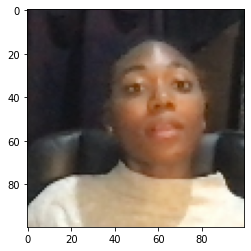

In [18]:
plt.imshow(dir_test_img)

In [19]:
#dataset.map(preprocess)

create labeled images

In [ ]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [20]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [21]:
data

<ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [22]:
samples = data.as_numpy_iterator()

In [23]:
example = samples.next()

Build Train and Test Partition

In [24]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [ ]:
# neg = negatives.as_numpy_iterator()
# neg.next()
# ex_neg = preprocess_twin(*ex_neg)
# plt.imshow(ex_neg)

In [25]:
res = preprocess_twin(*example)

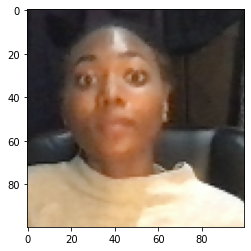

In [26]:
plt.imshow(res[0])

In [27]:
res[2]

1.0

In [28]:
#build data loader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [29]:
samples2 = data.as_numpy_iterator()

In [30]:
len(samples2.next())

3

In [31]:
#samples2.next()

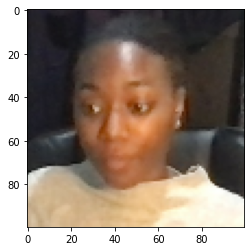

In [32]:
plt.imshow(samples2.next()[0])

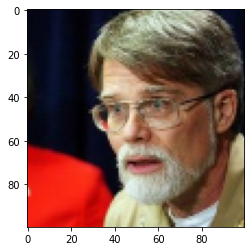

In [33]:
plt.imshow(samples2.next()[1])

In [34]:
samples2.next()[2]

0.0

In [35]:
#training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [36]:
train_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [37]:
train_samples = train_data.as_numpy_iterator()

In [38]:
train_sample = train_samples.next()

In [39]:
len(train_sample[0])

16

Model Engineering 

In [40]:
#testing partition
test_data = data.skip(round(len(data)*.7))
test_data = data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch (8)

Build Embedding Layer

In [63]:
inp = Input(shape =(100,100,3), name= 'input_image')

In [64]:
inp

<KerasTensor: shape=(None, 100, 100, 3) dtype=float32 (created by layer 'input_image')>

In [80]:
 c1 = Conv2D(64, (10,10), padding='valid', activation='relu', name= 'c1')(inp)

In [81]:
c1

<KerasTensor: shape=(None, 91, 91, 64) dtype=float32 (created by layer 'c1')>

In [82]:
 m1 =MaxPooling2D(64, (2,2), padding='same', data_format='channels_last', name ='m1')(c1)

In [83]:
m1

<KerasTensor: shape=(None, 46, 46, 64) dtype=float32 (created by layer 'm1')>

In [84]:
c2 = Conv2D(128, (7*7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2*2), padding='same')(c2)

ValueError: One of the dimensions in the output is <= 0 due to downsampling in conv2d_11. Consider increasing the input size. Received input shape [None, 46, 46, 64] which would produce output shape with a zero or negative value in a dimension.

In [70]:
c2

<KerasTensor: shape=(None, 5, 5, 128) dtype=float32 (created by layer 'conv2d_3')>

In [ ]:
 def make_embedding():
        inp = Input(shape =(100,100,3), name= 'input_image')
        #first block
        c1 = Conv2D(64, (10,10), activation='relu')(inp)
        #64 filters of shape 10*10 input inp
        m1 =MaxPooling2D(64, (2,2), padding='same')(c1)
        #64 units at 2*2, it will take the max value out of a 2*2 area and
        #return the max value. Is condesing the informaton
        
        #second block
        c2 = Conv2D(128, (7*7), activation='relu')(m1)
        m2 = MaxPooling2D(64, (2*2), padding='same')(c2)
        
        #third block
        c3 = Conv2D(128, (4*4) activation='relu')(m2)
        m3 = MaxPooling2D(64, (2*2), padding='same')(c3)
        
        #final embedding block
        c4 = Conv2D(256, (4*4), activation ='relu')(m3)
        
        f1 = Flatten()(c4)
        
        d1 = Dense(4096, acticvation='sigmoid')(f1)
        
        
        return Model(inputs=, outputs=, name=)

Build Distance Layer

Make Siamese Model

TRAINING